<a href="https://colab.research.google.com/github/kd303/trnsfrmr_pytrch_end_p1/blob/main/session_08_transformer/assignment_transformers_session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash 

python -m spacy download en
python -m spacy download de
python -m spacy download fr

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [ ]:
!pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IWSLT2016
from typing import Iterable, List

import spacy
import numpy as np

import random
import math
import time

## Here is what we are building...

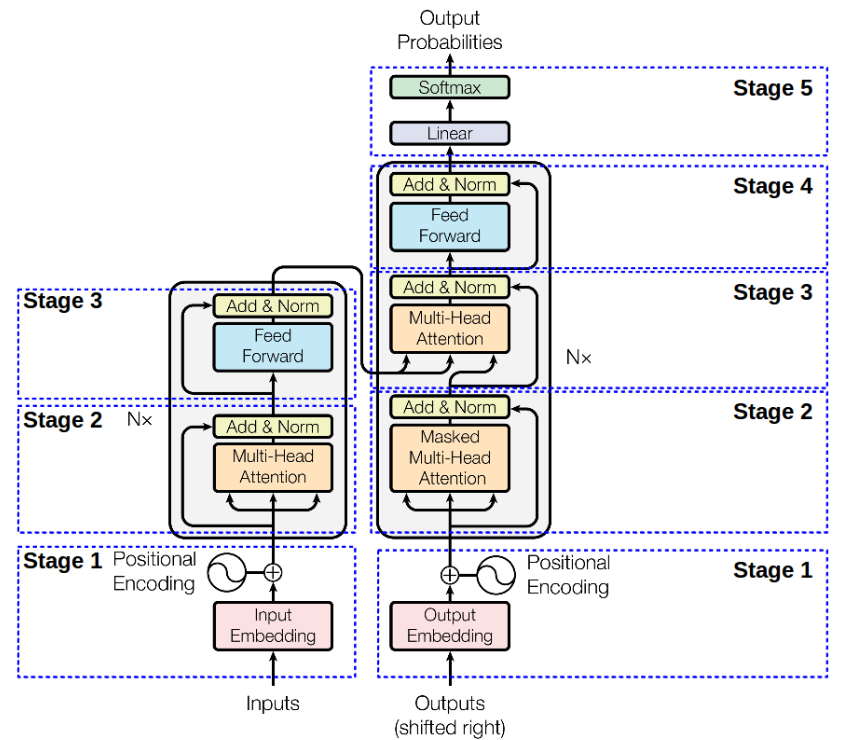

In [ ]:
##from google.colab import drive
## drive.mount('/content/drive')

**Torch** requires to use [deterministic algorithms](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms), hence the following variables are useful for [reproducibility](https://pytorch.org/docs/stable/notes/randomness.html) of the notebook 

[Some non-deterministic algorithms](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms) as per PyTorch doccumentation, most are convolution based, but ```torch.bmm()``` is notable exception

sr | Varible | Understanding
----- | ----- | --------
1 | ``torch.manual_seed(0)`` | Randon See for both CPU and CUDA devices
2 | ``torch.use_deterministic_algorithms()`` or <br> ``torch.backends.cudnn.deterministic = True``   | Allows to use deterministic algorithms to be used, does not mean <br> every execution will use different algorithms
3 | ``torch.backends.cudnn.benchmark = False`` | This will ensure reproducability across multiple exuections<br> unline deterministics algorithms, <br> one of two variables can e set


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
SRC_LANGUAGE = 'fr'
TGT_LANGUAGE = 'en'

In [ ]:
# place-holder directories
token_transform = {}
vocab_transform = {}

In [ ]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='fr')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')

In [ ]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure that tokens are in the or4der of their indices to properly insert them in Vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # training data iterator
  train_iter = IWSLT2016(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # create torchtext's vocab object ## changing for large datasets
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                  min_freq=2,
                                                  specials = special_symbols,
                                                  special_first=True
                                                  )

In [ ]:
# We need to set UNK_IDX as the defaul index. This index is requtrned when the token
# is not found. If this is NOT set, it throws RUNTIMEERROR when the queried token
# is not found in the vocabulary

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Multi-Headed Self Attention Layer

Basic Forumla for self Attention

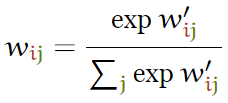

Pictorial Representation

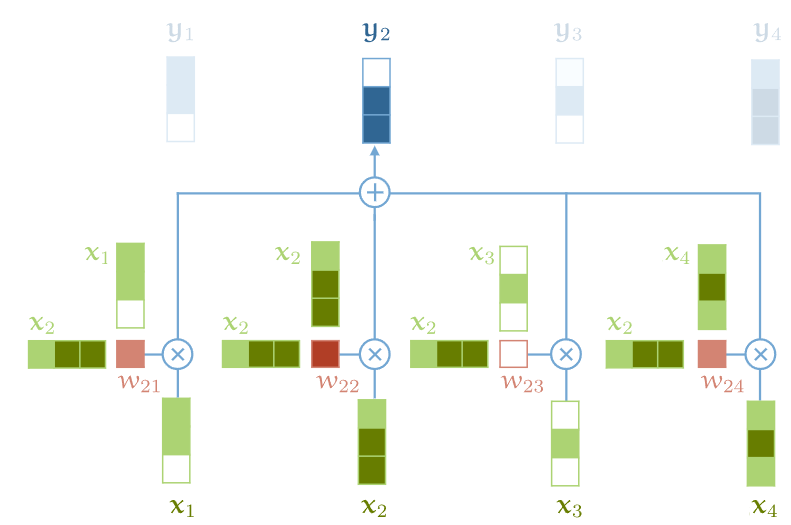

## Concept of Query Key and Value

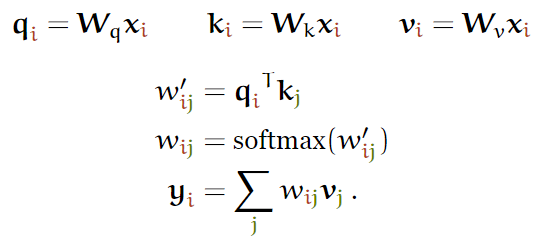

Pictorially representing same pictures

Basic self attention same vector x is used three ways 
- compared to every other vector to determine its own output
- compared to every vector to established the wieghts of ouput of j-the vector
- part of weighted sum to compute once the wieghts are established

These roles are often call Query, Key and Value respectively. 

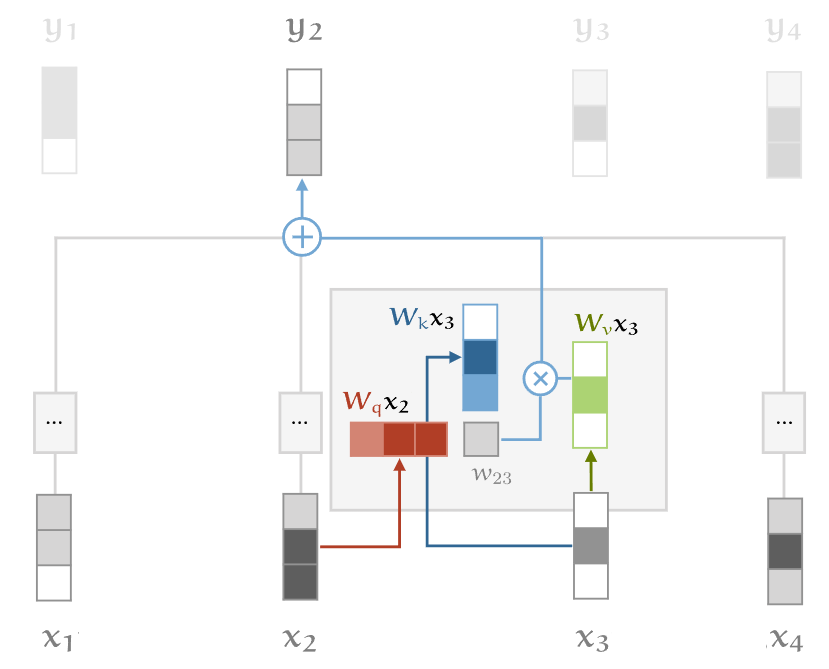


Once we establish the Q, K and V weights, if the each word can mean different thing to different neighbours "Mary gave a role to Luis" - word gave has different relationship with Mary and Luis as giver and reciever respectively. so in simple self-attention since the vecoters get averaged across all words the sentence "Luie gave a role to Mary" would mean the same thing. So to give grater power of discription we combining several self attention mechanisms by giving (multiple heads) to the attention. Same can be batch multipled to ensure that appropriate parrallelism is achieved.

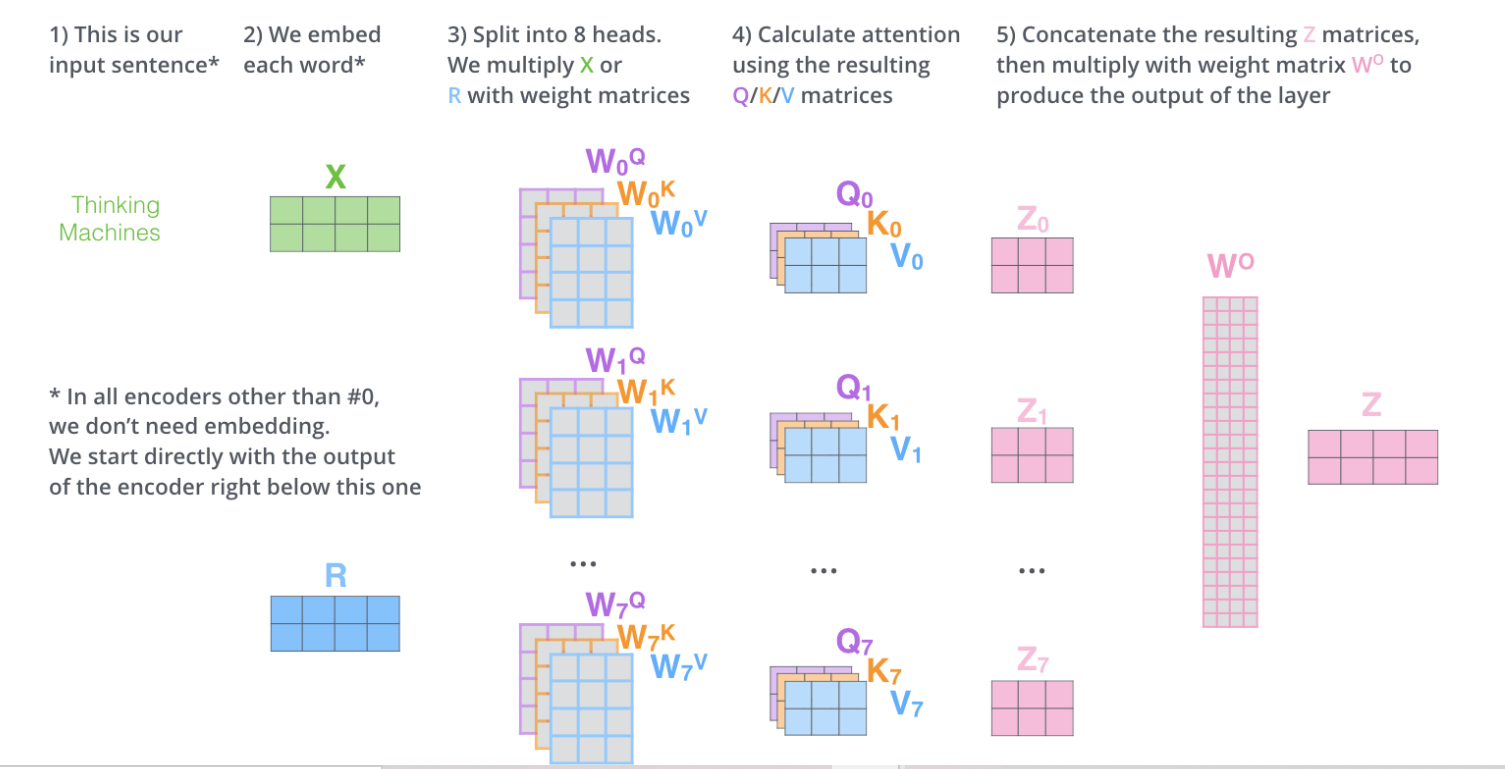

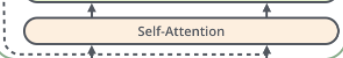

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        # hid_dim is the dimension of the word
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        # to ensure we have head dimensions for multiple heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        ## following are steps:
        # Q to start [batch size, query len, hid dim]
        #  Q.view(batch_size, -1, self.n_heads, self.head_dim) -> [batch_size, query_len, n_heads, hid_dim]       
        #  Q.permute(0, 2, 1, 3) -> [batch_size, n_heads, query_len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        # permute basically transposes the key in order to effectively multiply it

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        ## To ensure for decoder, whereever we mask, we fill with zero (very small value gradient dying) 
        # Not used for encorder
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)

        
        #attention = [batch size, n heads, query len, key len]
        #V = [batch size, n heads, value len, head dim]

        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

## Position Wise Feedforward

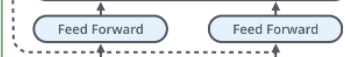

In [ ]:
## only class where relu is there, everywhere else we are using basic torch.matmul
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

## Encoder Layer

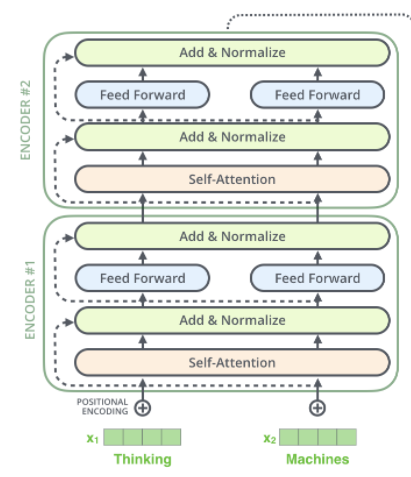

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, dropout(residual connection) and layer norm - " Add and Normazlie" green box above
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward - blue boxes two FC layers - purpose?!
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm - "Add and Normalize" second green box
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

## Encoder - putting all together

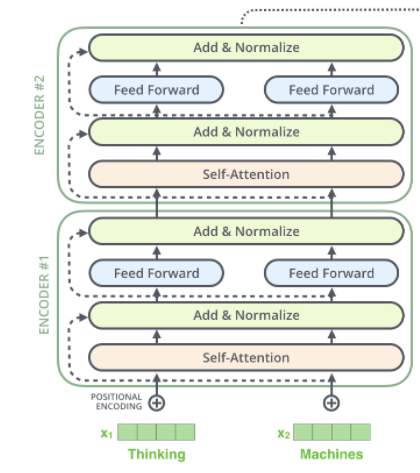


In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        # token embedding
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # Positional encodeing, just above gree boxes to learn word positions
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        ## number of encoders
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # Declaring emplyt random tensor for learning positional embeeding
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        ## Adding Positional embeeding vector with token embeeding and scaling 
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        ## stacking all up
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

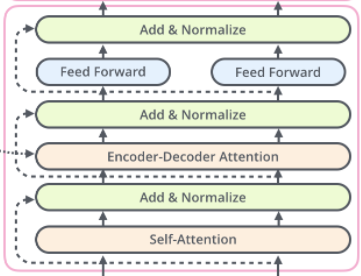

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        ## first multi-head layer
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        ## Encoder-Decoder Attention Layer - second attention layer
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        ## Blue feed forwards as mentioned above
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

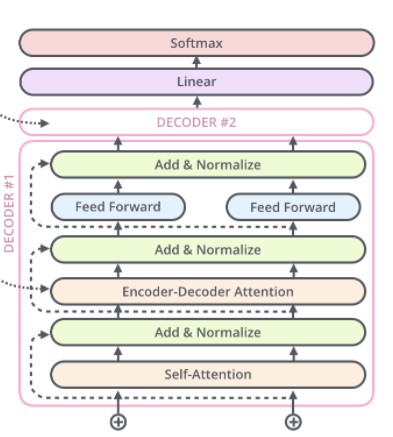

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

## TRansfomer ...

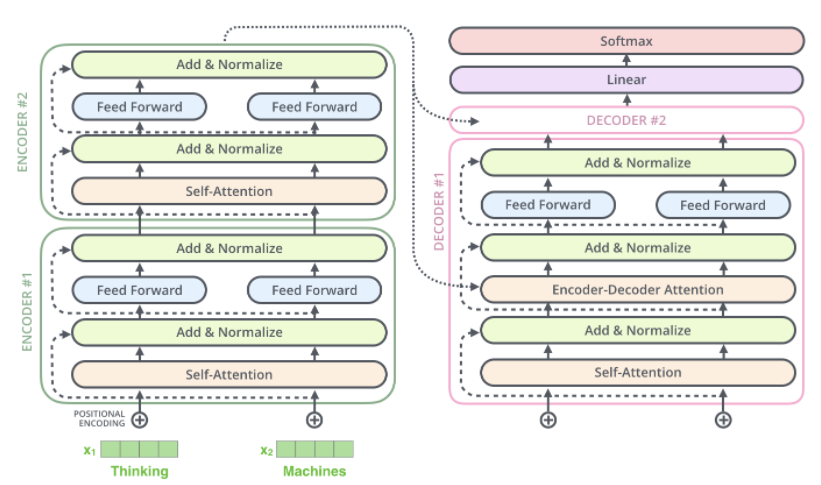

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
BATCH_SIZE = 64
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
PAD_IDX, INPUT_DIM, OUTPUT_DIM ## 30K DB (1, 19206 , 10840)

(1, 1699, 1533)

In [ ]:
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,226,237 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
######################################################################
# Collation
# ---------
#   
# As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
# We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
# defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
# can be fed directly into our model.   
#


from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Thu Jan 20 20:23:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    37W / 250W |   2861MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## for debugging purposes

from torch.utils.data import DataLoader
def d_debug():
    losses = 0
    train_iter = IWSLT2016(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src, tgt in train_dataloader:
      if src.shape[1] < 94 and tgt.shape[1] < 94:
        print(" source batch ", src.shape)
        print(" target batch ", tgt.shape)
      


In [ ]:
d_debug()

 source batch  torch.Size([64, 83])
 target batch  torch.Size([64, 75])
 source batch  torch.Size([64, 45])
 target batch  torch.Size([64, 42])
 source batch  torch.Size([64, 52])
 target batch  torch.Size([64, 53])
 source batch  torch.Size([64, 62])
 target batch  torch.Size([64, 56])
 source batch  torch.Size([64, 92])
 target batch  torch.Size([64, 93])
 source batch  torch.Size([64, 68])
 target batch  torch.Size([64, 83])
 source batch  torch.Size([64, 90])
 target batch  torch.Size([64, 71])
 source batch  torch.Size([64, 61])
 target batch  torch.Size([64, 61])
 source batch  torch.Size([64, 58])
 target batch  torch.Size([64, 49])
 source batch  torch.Size([64, 66])
 target batch  torch.Size([64, 60])
 source batch  torch.Size([64, 78])
 target batch  torch.Size([64, 73])
 source batch  torch.Size([64, 56])
 target batch  torch.Size([64, 48])
 source batch  torch.Size([2, 39])
 target batch  torch.Size([2, 35])


In [ ]:
######################################################################
# Let's define training and evaluation loop that will be called for each 
# epoch.
#

from torch.utils.data import DataLoader
MAX_LEN = 100

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = IWSLT2016(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    len = 1
    for src, tgt in train_dataloader:
       if src.shape[1] < MAX_LEN and tgt.shape[1] < MAX_LEN:
          # print(" source batch ", src.shape)
          # print(" target batch ", tgt.shape)
          src = src.to(device)
          tgt = tgt.to(device)
          
          # print(tgt[:,:-1].shape)

          optimizer.zero_grad()
          output, _ = model(src, tgt[:,:-1]) #[:,:-1])

          output_dim = output.shape[-1]
              
          output = output.contiguous().view(-1, output_dim)
          tgt = tgt[:,1:].contiguous().view(-1)

          # output = output[1:].view(-1, output.shape[-1])
          # tgt = tgt[1:].reshape(-1) #tgt[:,:-1][1:].reshape(-1)
          loss = loss_fn(output, tgt)
          loss.backward()
          clip = 1
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

          optimizer.step()
          losses += loss.item()
          len += 1

    return losses / len


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = IWSLT2016(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    len = 0
    for src, tgt in val_dataloader:
      if src.shape[1] < MAX_LEN and tgt.shape[1] < MAX_LEN:
        src = src.to(device)
        tgt = tgt.to(device)[:,:-1]

        output, _ = model(src, tgt[:,:-1])
            
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1)
        loss = loss_fn(output, tgt)
        losses += loss.item()
        len += 1
    return losses / len


In [ ]:
!nvidia-smi

Thu Jan 20 20:23:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    37W / 250W |   2861MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    end_time = timer()
    val_loss = evaluate(model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train PPL: {math.exp(train_loss):7.3f} | Val loss: {val_loss:.3f}, Val. PPL: {math.exp(val_loss):7.3f} | "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch: 1, Train loss: 2.891, Train PPL:  18.011 | Val loss: 2.246, Val. PPL:   9.448 | Epoch time = 328.511s
Epoch: 2, Train loss: 2.195, Train PPL:   8.979 | Val loss: 1.918, Val. PPL:   6.809 | Epoch time = 325.406s
Epoch: 3, Train loss: 1.991, Train PPL:   7.319 | Val loss: 1.786, Val. PPL:   5.963 | Epoch time = 324.587s
Epoch: 4, Train loss: 1.877, Train PPL:   6.536 | Val loss: 1.710, Val. PPL:   5.527 | Epoch time = 324.164s
Epoch: 5, Train loss: 1.804, Train PPL:   6.074 | Val loss: 1.663, Val. PPL:   5.275 | Epoch time = 318.135s
Epoch: 6, Train loss: 1.751, Train PPL:   5.758 | Val loss: 1.622, Val. PPL:   5.062 | Epoch time = 316.352s
Epoch: 7, Train loss: 1.709, Train PPL:   5.522 | Val loss: 1.595, Val. PPL:   4.927 | Epoch time = 314.859s
Epoch: 8, Train loss: 1.674, Train PPL:   5.336 | Val loss: 1.575, Val. PPL:   4.831 | Epoch time = 313.817s
Epoch: 9, Train loss: 1.644, Train PPL:   5.176 | Val loss: 1.555, Val. PPL:   4.734 | Epoch time = 314.255s
Epoch: 10, Train lo

In [ ]:
test_loss = evaluate(model)

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, init_token, eos_token, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)
    else:
        src_tensor = text_transform[TGT_LANGUAGE](sentence).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field[init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field[eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.get_itos()[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
data_iter = IWSLT2016(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
c = 0

print("*"*40)
print("German to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) French Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  # print("Attention Map: ")
  # display_attention(src, pred, attention)

  c += 1
  if c >= 10:
    break

****************************************
German to English Translations:-
****************************************


1) French Sentence: Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.

Target English Sentence: When I was in my 20s, I saw my very first psychotherapy client.

Predicted English Sentence: When I had the <unk> , I saw my first <unk> like <unk> .


2) French Sentence: J'étais étudiante en thèse en psychologie clinique à Berkeley.

Target English Sentence: I was a Ph.D. student in clinical psychology at Berkeley.

Predicted English Sentence: I was <unk> in <unk> <unk> in <unk> .


3) French Sentence: Elle, c'était une femme de 26 ans appelée Alex.

Target English Sentence: She was a 26-year-old woman named Alex.

Predicted English Sentence: She was a <unk> - old woman called <unk> .


4) French Sentence: Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un grand top trop large, elle s'est laissée tomber sur le canap

****************************************
Frechn to English Translations:-
****************************************


1) German Sentence: Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.

Target English Sentence: When I was in my 20s, I saw my very first psychotherapy client.

Predicted English Sentence: When I had the <unk> , I saw my first <unk> like <unk> .
Attention Map: 


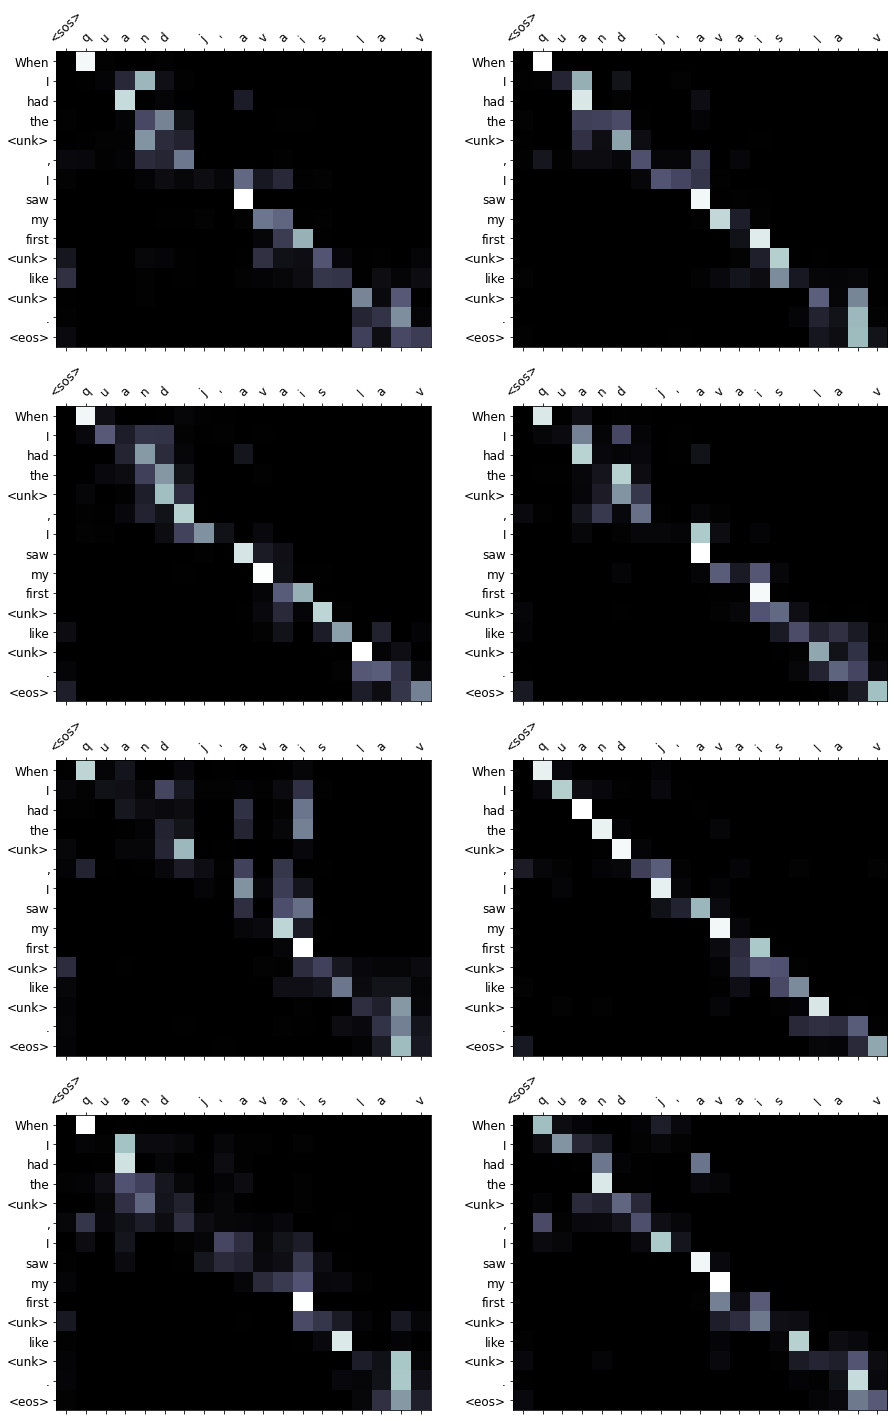



2) German Sentence: J'étais étudiante en thèse en psychologie clinique à Berkeley.

Target English Sentence: I was a Ph.D. student in clinical psychology at Berkeley.

Predicted English Sentence: I was <unk> in <unk> <unk> in <unk> .
Attention Map: 


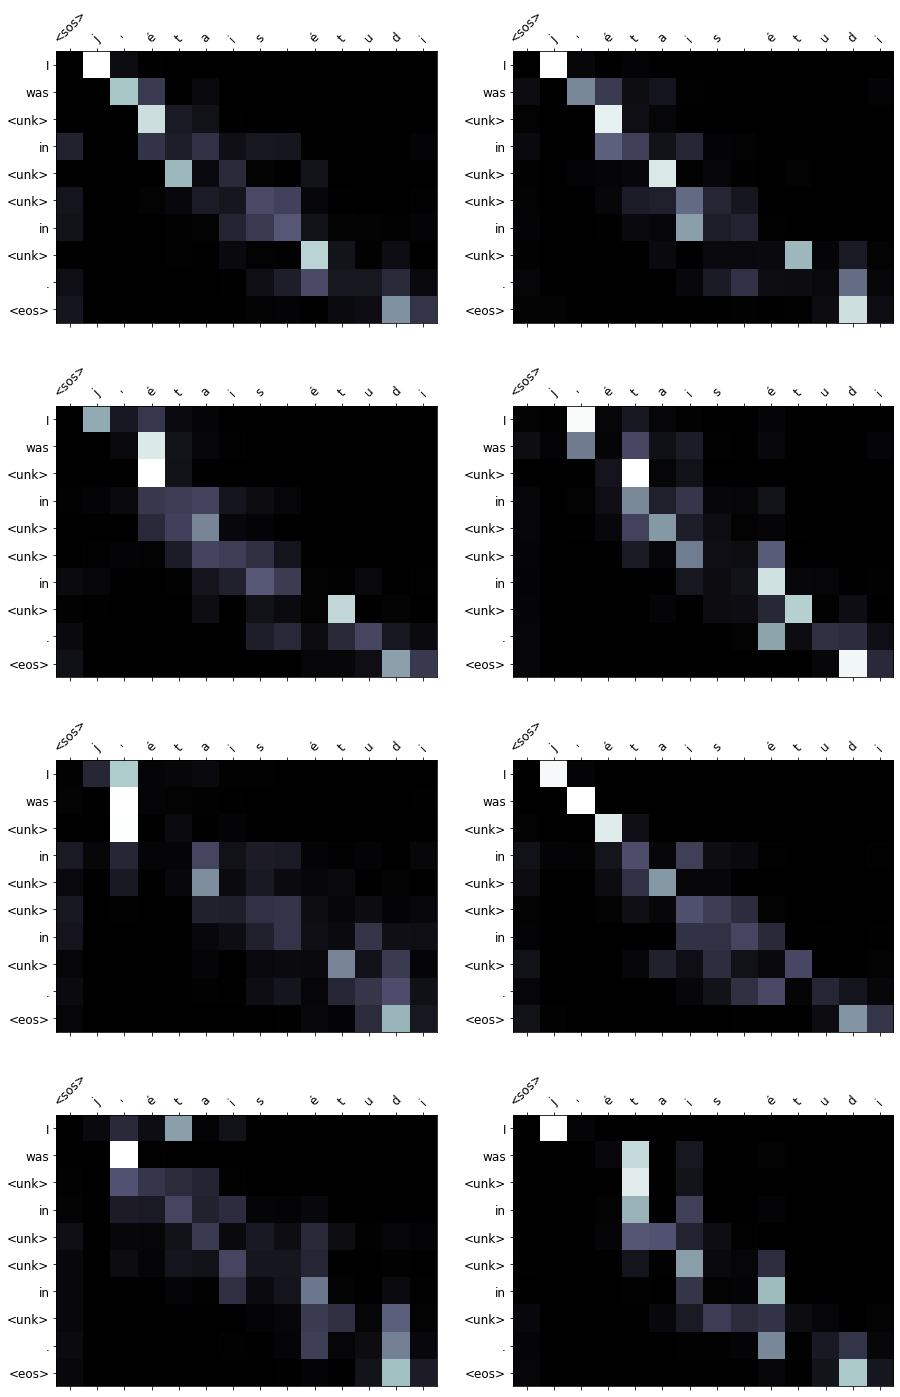



3) German Sentence: Elle, c'était une femme de 26 ans appelée Alex.

Target English Sentence: She was a 26-year-old woman named Alex.

Predicted English Sentence: She was a <unk> - old woman called <unk> .
Attention Map: 


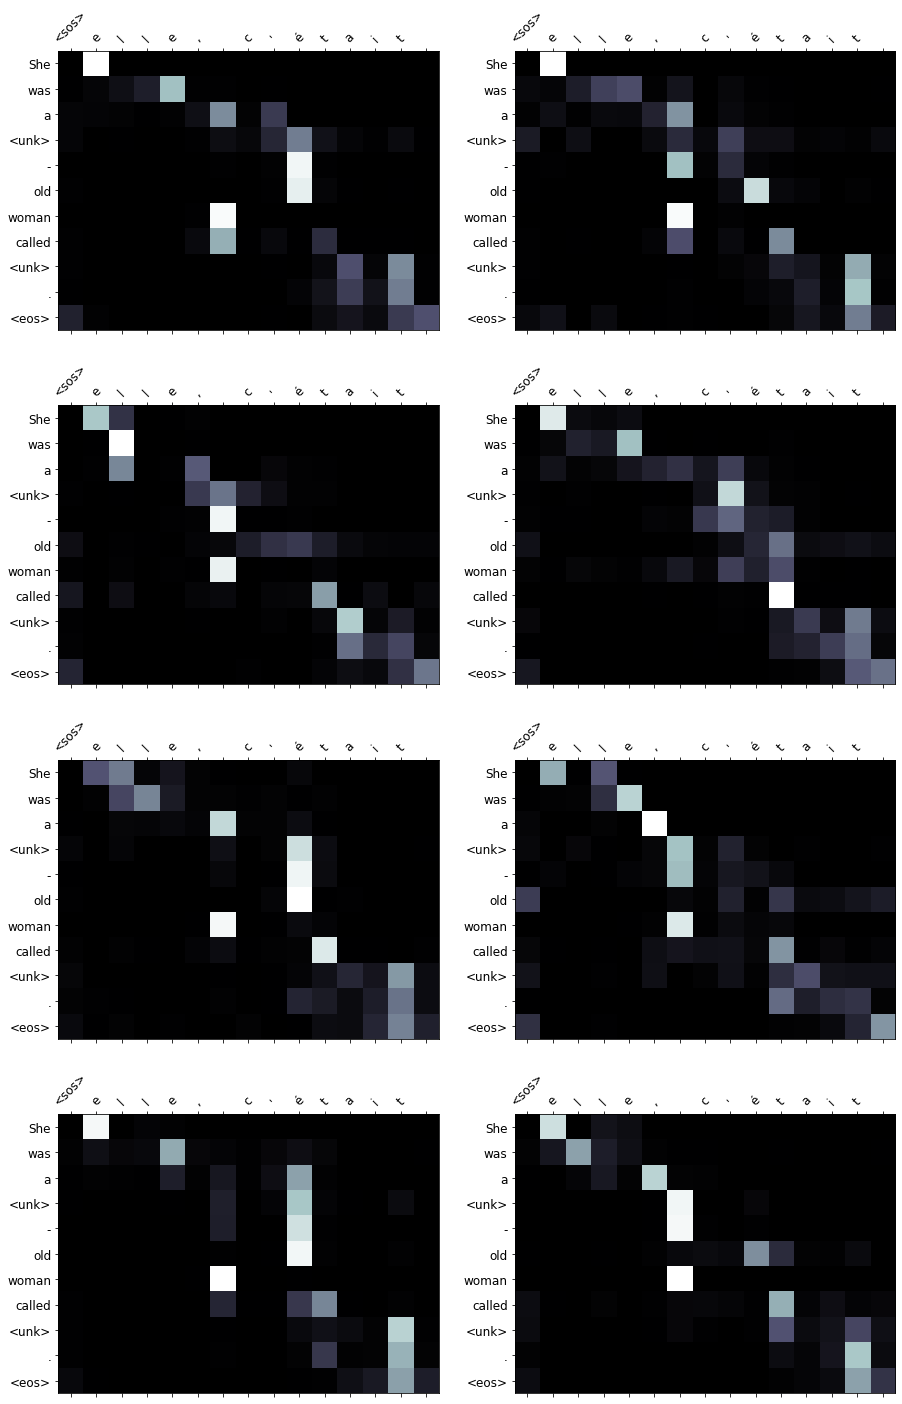



4) German Sentence: Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un grand top trop large, elle s'est laissée tomber sur le canapé de mon bureau, a enlevé ses chaussures et m'a dit qu'elle était ici pour parler de problèmes de garçons.

Target English Sentence: Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.

Predicted English Sentence: <unk> <unk> went to his first <unk> , she <unk> a <unk> and a <unk> <unk> <unk> , she <unk> <unk> on the <unk> of my <unk> , <unk> her <unk> , and told me she was here to talk about boys .
Attention Map: 


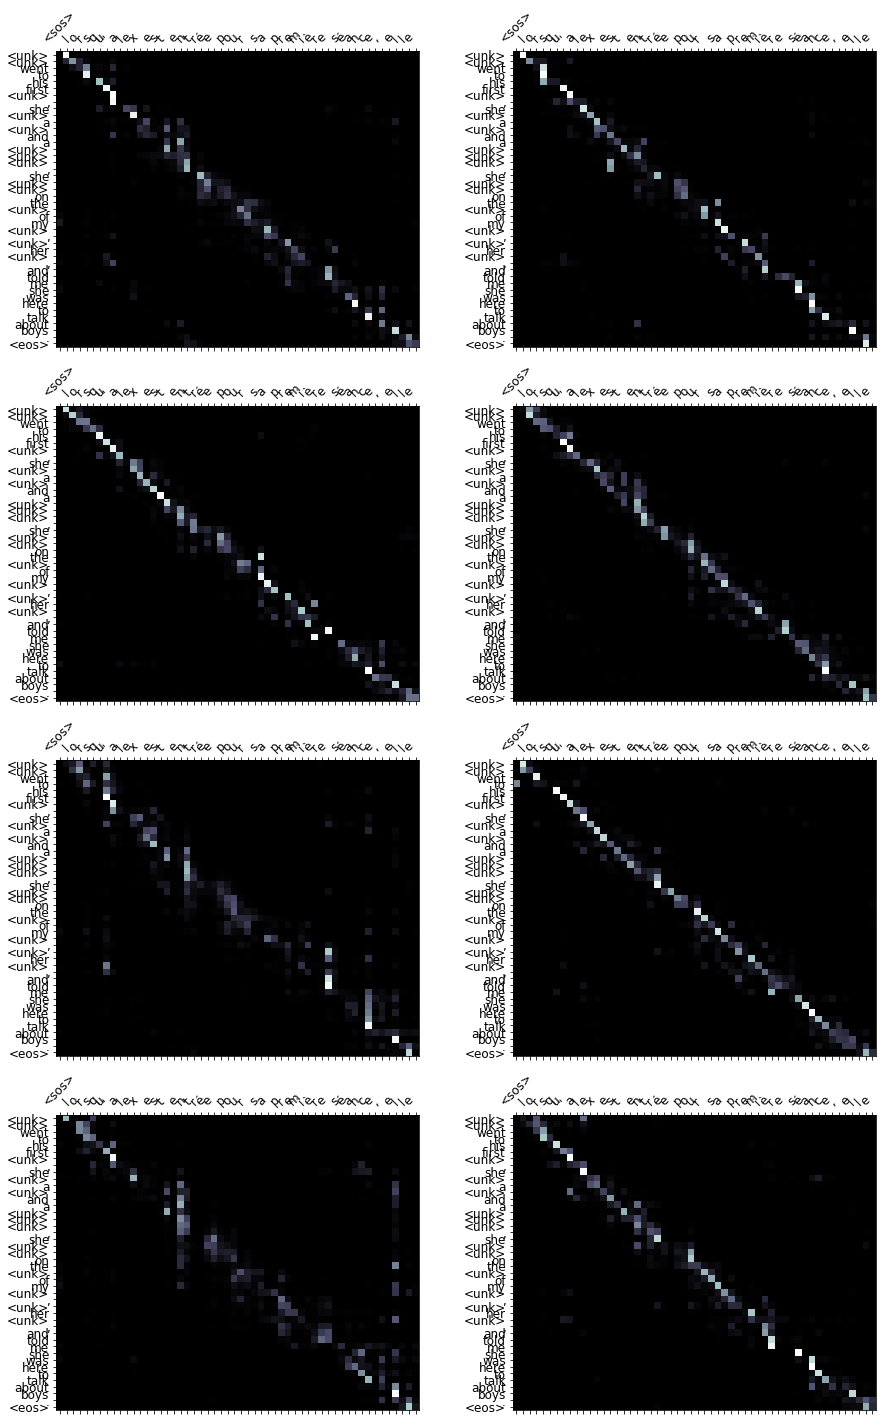



5) German Sentence: Lorsque j'ai entendu ça, j'ai été si soulagée.

Target English Sentence: Now when I heard this, I was so relieved.

Predicted English Sentence: And then I heard this , I was so <unk> .
Attention Map: 


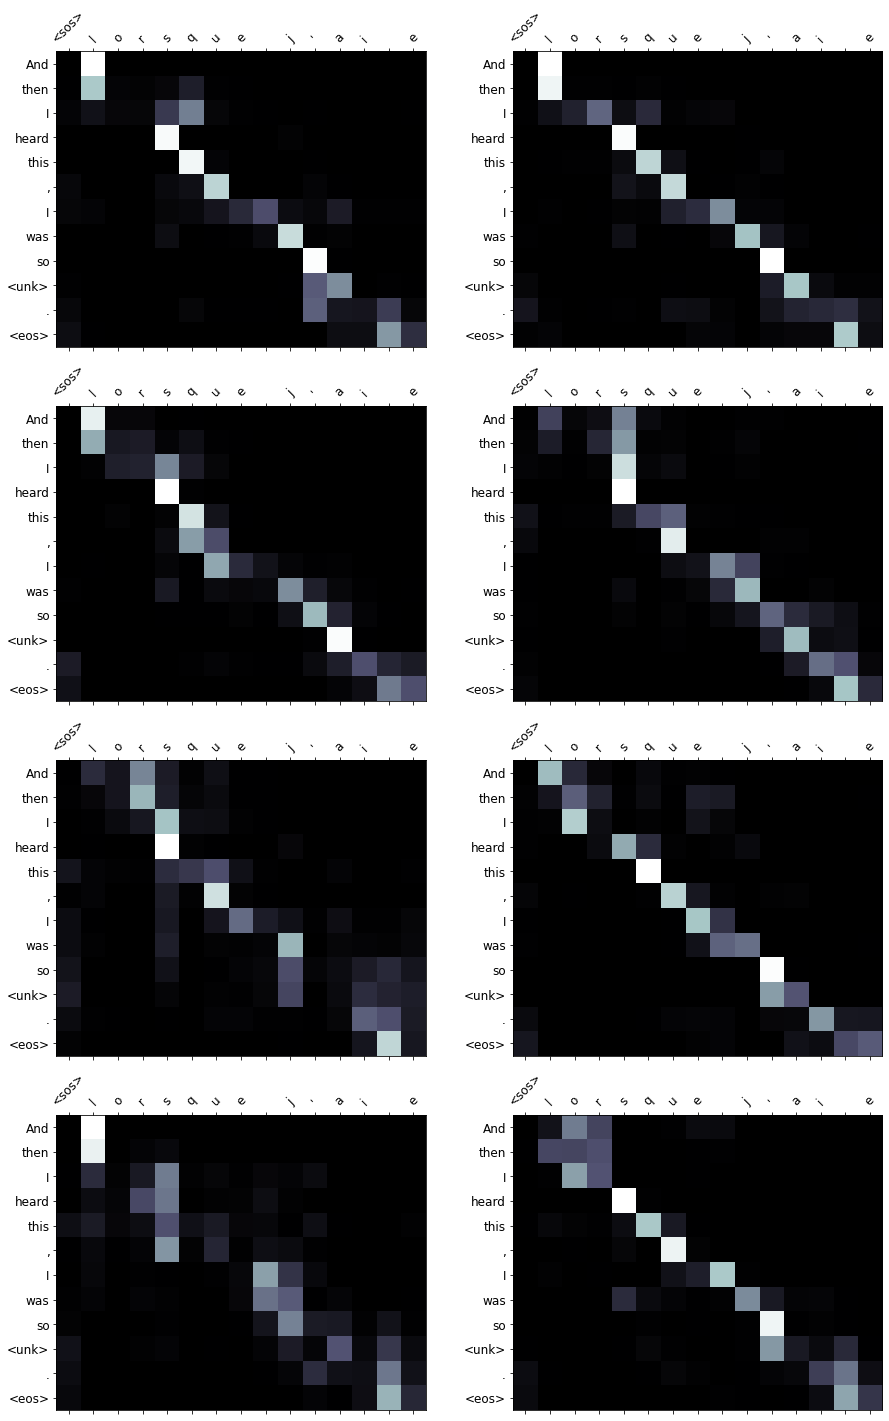

In [ ]:
data_iter = IWSLT2016(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
c = 0

print("*"*40)
print("Frechn to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) German Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  print("Attention Map: ")
  display_attention(src, pred, attention)

  c += 1
  if c >= 5:
    break

In [ ]:
!nvidia-smi

Sun Jan  2 05:37:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |   3689MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------